# Toxicity analysis of Reddit AITA dataset for each AITA class
- Uses Toxigen RoBERTa model (https://huggingface.co/tomh/toxigen_roberta) as a toxicity classifier where LABEL_0 = "BENIGN" and LABEL_1 = "TOXIC"

In [ ]:
%pip install transformers datasets huggingface_hub tqdm matplotlib accelerate

In [ ]:
# mount drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/CPSS_24_Paper/results

import os
os.makedirs('toxicity_analysis', exist_ok=True)

%cd /content/drive/MyDrive/CPSS_24_Paper/results/toxicity_analysis

/content/drive/MyDrive/CPSS_24_Paper/results
/content/drive/MyDrive/CPSS_24_Paper/results/toxicity_analysis


## Prepare Dataset

In [ ]:
from datasets import load_dataset, concatenate_datasets

dataset = load_dataset("MattBoraske/Reddit-AITA-2018-to-2022-with-consensus")

## Classify Samples of Dataset as Toxic or Benign

In [ ]:
from transformers import pipeline

# load toxigen roberta model
toxigen_roberta = pipeline("text-classification", model="tomh/toxigen_roberta", truncation=True, device_map='cuda')

# LABEL 0 = NON-TOXIC
# LABEL 1 = TOXIC

In [ ]:
import pandas as pd

counter = 0

def calculate_toxicity(row):
    # classify top comment 1 as toxic or benign using toxigen roberta model and also get confidence score
    toxicity_score = toxigen_roberta(row['top_comment_1'])
    toxicity_label = toxicity_score[0]['label']
    if toxicity_label == 'LABEL_0': # LABEL 0 = BENIGN
      toxicity_label = 'BENIGN'
    else:
      toxicity_label = 'TOXIC' # LABEL 1 = TOXIC
    toxicity_score = toxicity_score[0]['score']

    global counter
    counter += 1
    if counter % 250 == 0:
      print(f'Processed {counter} samples')

    return pd.Series({
        'toxicity_label': toxicity_label,
        'toxicity_confidence_score': toxicity_score
    })

# calculate toxicity for each sample in dataset
df = dataset['train'].to_pandas()
df[['toxicity_label', 'toxicity_confidence_score']] = df.apply(calculate_toxicity, axis=1, result_type='expand')

In [ ]:
# add toxicity label and confidence score columns to the dataset

dataset['train'] = dataset['train'].add_column('toxicity_label', df['toxicity_label'])
dataset['train'] = dataset['train'].add_column('toxicity_confidence_score', df['toxicity_confidence_score'])

In [ ]:
# save dataset to huggingface

dataset.push_to_hub("MattBoraske/Reddit-AITA-2018-to-2022-with-consensus-and-toxicity-analysis")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/30 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/MattBoraske/Reddit-AITA-2018-to-2022-with-consensus-and-toxicity-analysis/commit/8318760573b47086bb686ed0884d687aca1b5f5f', commit_message='Upload dataset', commit_description='', oid='8318760573b47086bb686ed0884d687aca1b5f5f', pr_url=None, pr_revision=None, pr_num=None)

## Analyze Results

In [ ]:
df = dataset['train'].to_pandas()

In [ ]:
# filter df to only contain samples where top_comment_1_AITA_class_by_keyword is NTA

df_NAH = df[df['top_comment_1_AITA_class_by_keyword'] == 1]
df_NTA = df[df['top_comment_1_AITA_class_by_keyword'] == 2]
df_YTA = df[df['top_comment_1_AITA_class_by_keyword'] == 3]
df_ESH = df[df['top_comment_1_AITA_class_by_keyword'] == 4]

In [ ]:
# save consensus stats to output JSON

import json

toxicity_stats = {
    "All Classes": {
        'counts': df['toxicity_label'].value_counts().to_dict(),
        'percentiles': ((df['toxicity_label'].value_counts() / df['toxicity_label'].value_counts().sum()) * 100).to_dict()
    },
    "NTA": {
        'counts': df_NTA['toxicity_label'].value_counts().to_dict(),
        'percentiles': ((df_NTA['toxicity_label'].value_counts() / df_NTA['toxicity_label'].value_counts().sum()) * 100).to_dict()
    },
    "YTA": {
        'counts': df_YTA['toxicity_label'].value_counts().to_dict(),
        'percentiles': ((df_YTA['toxicity_label'].value_counts() / df_YTA['toxicity_label'].value_counts().sum()) * 100).to_dict()
    },
    "NAH": {
        'counts': df_NAH['toxicity_label'].value_counts().to_dict(),
        'percentiles': ((df_NAH['toxicity_label'].value_counts() / df_NAH['toxicity_label'].value_counts().sum()) * 100).to_dict()
    },
    "ESH": {
        'counts': df_ESH['toxicity_label'].value_counts().to_dict(),
        'percentiles': ((df_ESH['toxicity_label'].value_counts() / df_ESH['toxicity_label'].value_counts().sum()) * 100).to_dict()
    }
}

with open('toxicity_stats_by_AITA_class.json', 'w') as f:
    json.dump(toxicity_stats, f)

<ipython-input-54-7e80c7305d04>:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


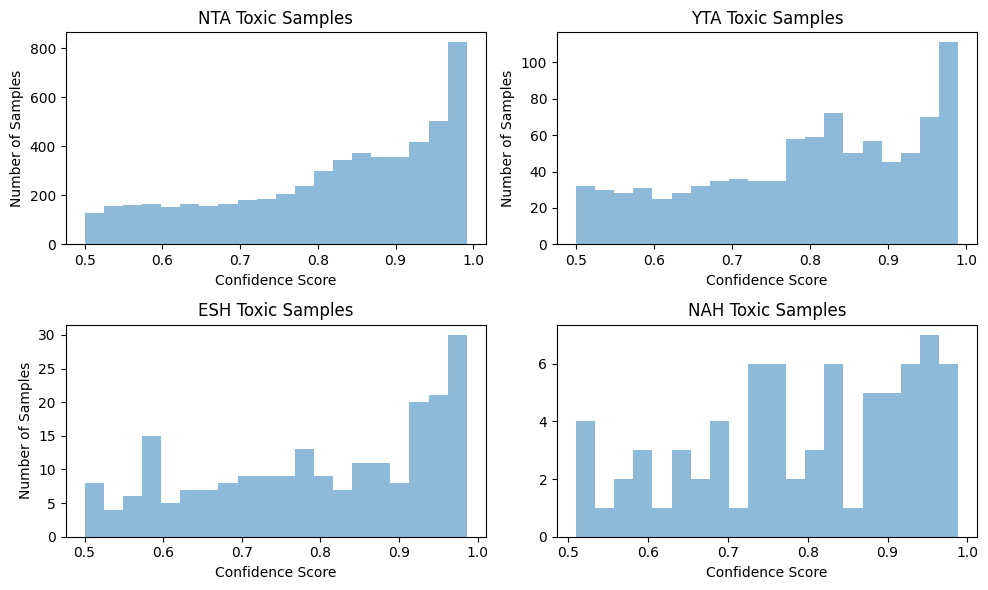

In [ ]:
import matplotlib.pyplot as plt

# histograms of the toxic samples for each AITA decision class

# extract confidence scores of toxic samples for the four AITA decision classes
toxic_samples_NTA = df_NTA[df_NTA['toxicity_label'] == 'TOXIC']['toxicity_confidence_score'].to_list()
toxic_samples_YTA = df_YTA[df_YTA['toxicity_label'] == 'TOXIC']['toxicity_confidence_score'].to_list()
toxic_samples_ESH = df_ESH[df_ESH['toxicity_label'] == 'TOXIC']['toxicity_confidence_score'].to_list()
toxic_samples_NAH = df_NAH[df_NAH['toxicity_label'] == 'TOXIC']['toxicity_confidence_score'].to_list()

#plot 4 histograms as a 2x2 subplot
plt.figure(figsize=(10, 6))
plt.title(f'Reddit AITA Toxic Samples')
# NTA
plt.subplot(2, 2, 1)
plt.hist(toxic_samples_NTA, bins=20, alpha=0.5)
plt.title('NTA Toxic Samples')
plt.xlabel('Confidence Score')
plt.ylabel('Number of Samples')
# YTA
plt.subplot(2, 2, 2)
plt.hist(toxic_samples_YTA, bins=20, alpha=0.5)
plt.title('YTA Toxic Samples')
plt.xlabel('Confidence Score')
plt.ylabel('Number of Samples')
# ESH
plt.subplot(2, 2, 3)
plt.hist(toxic_samples_ESH, bins=20, alpha=0.5)
plt.title('ESH Toxic Samples')
plt.xlabel('Confidence Score')
plt.ylabel('Number of Samples')
# NAH
plt.subplot(2, 2, 4)
plt.hist(toxic_samples_NAH, bins=20, alpha=0.5)
plt.title('NAH Toxic Samples')
plt.xlabel('Confidence Score')
# plot details
plt.tight_layout()
plt.savefig('toxic_confidence_by_AITA_class.png')
plt.show()

<ipython-input-55-b69407701b93>:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


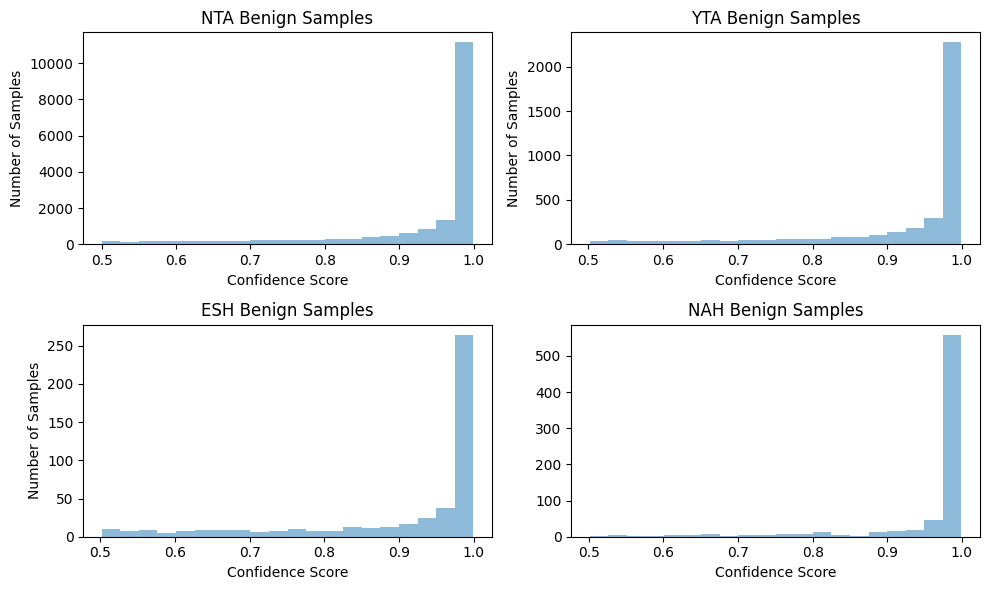

In [ ]:
# histogram of the benign samples for each AITA class partition

# extract confidence scores of toxic samples for the four AITA decision classes
benign_samples_NTA = df_NTA[df_NTA['toxicity_label'] == 'BENIGN']['toxicity_confidence_score'].to_list()
benign_samples_YTA = df_YTA[df_YTA['toxicity_label'] == 'BENIGN']['toxicity_confidence_score'].to_list()
benign_samples_ESH = df_ESH[df_ESH['toxicity_label'] == 'BENIGN']['toxicity_confidence_score'].to_list()
benign_samples_NAH = df_NAH[df_NAH['toxicity_label'] == 'BENIGN']['toxicity_confidence_score'].to_list()

#plot 4 histograms as a 2x2 subplot
plt.figure(figsize=(10, 6))
plt.title(f'Reddit AITA Benign Samples')
# NTA
plt.subplot(2, 2, 1)
plt.hist(benign_samples_NTA, bins=20, alpha=0.5)
plt.title('NTA Benign Samples')
plt.xlabel('Confidence Score')
plt.ylabel('Number of Samples')
# YTA
plt.subplot(2, 2, 2)
plt.hist(benign_samples_YTA, bins=20, alpha=0.5)
plt.title('YTA Benign Samples')
plt.xlabel('Confidence Score')
plt.ylabel('Number of Samples')
# ESH
plt.subplot(2, 2, 3)
plt.hist(benign_samples_ESH, bins=20, alpha=0.5)
plt.title('ESH Benign Samples')
plt.xlabel('Confidence Score')
plt.ylabel('Number of Samples')
# NAH
plt.subplot(2, 2, 4)
plt.hist(benign_samples_NAH, bins=20, alpha=0.5)
plt.title('NAH Benign Samples')
plt.xlabel('Confidence Score')
# plot details
plt.tight_layout()
plt.savefig('benign_confidence_by_AITA_class.png')
plt.show()

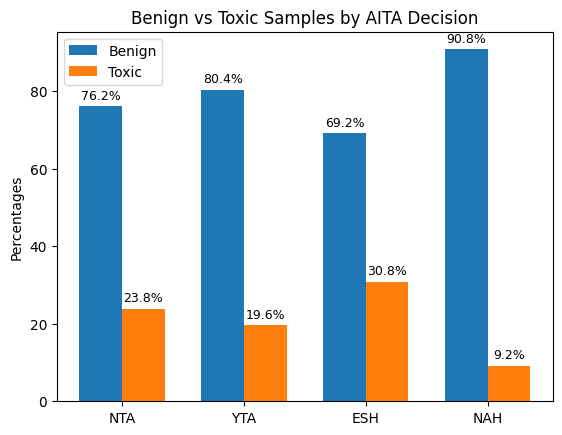

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# create 2-bar chart of toxic and benign proportions for each AITA class

categories = ['NTA', 'YTA', 'ESH', 'NAH']

benign_counts = {
    'NTA': df_NTA['toxicity_label'].value_counts()['BENIGN'],
    'YTA': df_YTA['toxicity_label'].value_counts()['BENIGN'],
    'ESH': df_ESH['toxicity_label'].value_counts()['BENIGN'],
    'NAH': df_NAH['toxicity_label'].value_counts()['BENIGN'],
}

toxic_counts = {
    'NTA': df_NTA['toxicity_label'].value_counts()['TOXIC'],
    'YTA': df_YTA['toxicity_label'].value_counts()['TOXIC'],
    'ESH': df_ESH['toxicity_label'].value_counts()['TOXIC'],
    'NAH': df_NAH['toxicity_label'].value_counts()['TOXIC'],
}

total_counts = {
    'NTA': df_NTA['toxicity_label'].value_counts().sum(),
    'YTA': df_YTA['toxicity_label'].value_counts().sum(),
    'ESH': df_ESH['toxicity_label'].value_counts().sum(),
    'NAH': df_NAH['toxicity_label'].value_counts().sum(),
}

benign_percentages = [(benign_counts[category] / total_counts[category]) * 100 for category in categories]
toxic_percentages = [(toxic_counts[category] / total_counts[category]) * 100 for category in categories]

x = np.arange(len(categories))  # Label locations
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, benign_percentages, width, label='Benign')
rects2 = ax.bar(x + width/2, toxic_percentages, width, label='Toxic')

# plot details
ax.set_ylabel('Percentages')
ax.set_title('Benign vs Toxic Samples by AITA Decision')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# add labels to bars
def add_bar_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

add_bar_labels(rects1)
add_bar_labels(rects2)

plt.savefig('toxic_proportions_by_AITA_class.png')
plt.show()